# Модель для прогнозирования оттока клиентов для сервиса доставки кофе


- Автор: Оливия Щербакова
- Дата: 08.02.2026

**Задача:** построить модель бинарной классификации, которая спрогнозирует вероятность оттока каждого клиента в следующем месяце.

### Описание данных

Для разработки модели предоставлены данные из внутренних систем компании. База данных  coffee_churn_dataset:
- `coffee_churn_dataset` - содержит данные собранные из внутренних систем компании: транзакционной базы данных, логов мобильного приложения и результатов опросов.

**Описание датасета `coffee_churn_dataset`:**
- `user_id` — идентификатор пользователя.
- `days_since_last_order` — количество дней, прошедших с последнего заказа.
- `order_frequency_month` — среднее число заказов в месяц.
- `order_frequency_week` — среднее число заказов в неделю.
- `avg_order_value` — средний чек, в рублях.
`median_order_value` — медианный чек, в рублях.
- `total_spent_last_month` — сумма заказов за последний месяц.
- `total_spent_last_week` — сумма заказов за последнюю неделю.
- `discount_usage_rate` — доля заказов со скидкой за последний месяц.
- `last_coffee_type` — сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `preferred_roast` — предпочитаемый тип обжарки.
- `milk_preference` — предпочитаемый тип молока.
- `seasonal_menu_tried` — отметка о том, пробовал ли пользователь новейшее сезонное меню.
- `coffee_bean_origin` — страна происхождения зерна.
- `last_drink_size` — размер последнего заказа, совершённого на момент сбора данных.
- `subscription_status` — тип подписки пользователя.
- `app_opens_per_week` — сколько раз за неделю пользователь в среднем открывал приложение доставки кофе.
- `notifications_enabled` — включены ли у пользователя уведомления.
- `review_rating_last_10` — средняя оценка последних на момент сбора данных десяти заказов клиента.
- `review_rating_last_1` — оценка последнего на момент сбора данных заказа клиента.
- `app_crashes_last_month` — сколько раз приложение зависало за последний месяц.
- `seasons` — текущее время года.
- `days_since_last_promo` — сколько дней прошло с последнего использования акции или промокода.
- `phone_type` — тип устройства, с которого пользователь чаще всего совершал покупки.
- `coffee_preference_change` — менялись ли вкусовые предпочтения пользователя.
- `geo_id` — идентификатор региона пользователя.
- `churn` — перестал ли пользователь пользоваться сервисом.

### Содержимое проекта

1. Подготовка среды и библиотек.
2. Первичный анализ данных.
3. Предобработка данных.
4. Обучение модели.
5. Создание новых признаков.
6. Эксперименты с гиперпараметрами.
7. Подготовка финальной модели.
8. Отчёт о проделанной работе.
9. Сохранение модели для продакшена.

---

Тип модели:
- линейная модель — LogisticRegression. Это позволит бизнесу понять, какие признаки больше всего влияют на отток клиентов. В качестве базовой модели - DummyClassifier.

Целевой переменной будет: `churn - перестал ли пользователь пользоваться сервисом.

Метрики качества модели, которые будут использоваться: 
- Precision-Recall AUC (PR AUC).

# План работы

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [1]:
pip install joblib 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install scikit-learn==0.24.1

In [4]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from phik import phik_matrix

Необходимо закрепить версии библиотек. После чего зафиксировать их в файле `requirements.txt`.

In [5]:
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scikit-learn', sklearn.__version__)
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)
print('joblib', joblib.__version__)

numpy 1.21.1
pandas 1.2.4
scikit-learn 0.24.1
matplotlib 3.3.4
seaborn 0.11.1
joblib 1.5.3


Далее зафиксируем `random_state` для того, чтобы в дальнейшем использовать одно и то же значение.

In [6]:
#Фиксация random_state
RANDOM_STATE = 42

Загрузка данных из файла.

In [7]:
df_coffee = pd.read_csv('/datasets/coffee_churn_dataset.csv', sep = ',', decimal='.')

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

Проверим правильно ли прошла загрузка данных, а также познакомимся с данными.

In [8]:
df_coffee.head()

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1


In [9]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

Датасет `df_coffee` содержит 10450 строк и 27 столбцов, в которых предоставлена информация из внутренних систем компании. 

Изучим данные:
- **Строковые данные (object)**. Десять столбцов:
    - `user_id` идентификаторы имеют буквы и цифры, поэтому представлены в строковом формате, тип данных корректен.
    - `last_coffee_type`, `preferred_roast`, `milk_preference`, `coffee_bean_origin`, `last_drink_size` содержат информацию о предпочтениях клиента, поэтому тип данных корректен.
    - `subscription_status` показывает статус подписки, поэтому тип данных выбран верно. 
    - `seasons` - указывает текущее время года, тип данных корректен.
    - `phone_type`, `geo_location` - указаны данные о клиенте, тип данных корректен.
- **Числовые значения с плавающей запятой (float64)**. Шестнадцать столбцов:
    - `days_since_last_order`, `order_frequency_month`, `avg_order_value`, `order_frequency_week`, `median_order_value`, `total_spent_last_month`, `total_spent_last_week`, `discount_usage_rate`, `app_opens_per_week`, `review_rating_last_10`, `review_rating_last_1`,  содержит дробную информацию о заказах пользователя, поэтому данный формат подобран корректно.
    - `seasonal_menu_tried`, `notifications_enabled`, `app_crashes_last_month`, `days_since_last_promo`, `coffee_preference_change` - содержит числовую информацию о клиенте, тип данных выбран корректно.
- **Целочисленные данные (int64)**. Один столбец:
    - `churn`содержит информацию о том, перестал ли пользователь пользоваться сервисом, тип данных корректен.
    
Все значения в столбцах соответствуют своему описанию данных.

Далее рассмотрим распределение целевой переменной `сhurn` - перестал ли пользователь пользоваться сервисом.

In [10]:
display("Распределение целевой переменной")
df_coffee['churn'].value_counts()

'Распределение целевой переменной'

0    9821
1     629
Name: churn, dtype: int64

In [11]:
display("Доли распределения целевой переменной")
df_coffee['churn'].value_counts(normalize = True)

'Доли распределения целевой переменной'

0    0.939809
1    0.060191
Name: churn, dtype: float64

У целевой переменной наблюдается сильный дисбаланс, это заметно, потому что **положительный класс составляет ~ 6%**. Поэтому для оценки модели необходимо использовать метрику Precision-Recall AUC (PR AUC). 

Необходимо изучить категориальные признаки на дубликаты.

In [12]:
columns = ['last_coffee_type', 
           'preferred_roast', 
           'milk_preference',
           'coffee_bean_origin',
           'last_drink_size',
           'subscription_status',
           'seasons',
           'phone_type',
           'geo_location'
          ]

for column in columns:
    unique_col = df_coffee[column].unique()
    print(f'Уникальные значения в {column}: {unique_col}')

Уникальные значения в last_coffee_type: ['blend' 'arabica' 'robusta' nan]
Уникальные значения в preferred_roast: ['light' 'medium' 'dark' nan]
Уникальные значения в milk_preference: ['almond' 'whole' 'oat' 'skim' 'soy' nan 'none']
Уникальные значения в coffee_bean_origin: ['vietnam' 'guatemala' 'brazil' 'colombia' 'kenya' nan 'ethiopia']
Уникальные значения в last_drink_size: ['large' 'medium' 'small' nan]
Уникальные значения в subscription_status: ['pro' 'none' 'premium' 'basic' nan]
Уникальные значения в seasons: ['summer' 'autumn' 'spring' 'winter' nan]
Уникальные значения в phone_type: ['android' 'ios' 'web' nan]
Уникальные значения в geo_location: ['geo_75' 'geo_95' 'geo_25' 'geo_2' 'geo_19' 'geo_68' 'geo_3' 'geo_45'
 'geo_15' nan 'geo_30' 'geo_93' 'geo_64' 'geo_40' 'geo_87' 'geo_17'
 'geo_11' 'geo_94' 'geo_1' 'geo_50' 'geo_67' 'geo_51' 'geo_97' 'geo_16'
 'geo_78' 'geo_100' 'geo_98' 'geo_43' 'geo_8' 'geo_48' 'geo_61' 'geo_74'
 'geo_35' 'geo_59' 'geo_46' 'geo_5' 'geo_23' 'geo_91' '

В категориальных признаках не было обнаружено дубликатов.
Далее необходимо изучить признаки, которые необходимы  будут для модели.

Признаки, которые необходимо будет удалить: 
- `user_id` - идентификатор пользователя, из-за него модель может переобучиться

Признаки, которые необходимо оставить, которые указывают вовлеченность клиента:
- `days_since_last_order` - количество дней, прошедших с последнего заказа. Данный признак влияет на возвращение клиента
- `app_opens_per_week` - сколько раз за неделю пользователь в среднем открывал приложение доставки кофе. Чем реже клиент заходит в приложение, тем выше шанс оттока
- `subscription_status` -  тип подписки пользователя
- `notifications_enabled` - включены ли у пользователя уведомления
- `discount_usage_rate` -  доля заказов со скидкой за последний месяц
- `days_since_last_promo` - сколько дней прошло с последнего использования акции или промокода
- `app_crashes_last_month` - сколько раз приложение зависало за последний месяц

Признаки, которые могут быть важны, но необходимо будет рассмотреть их корреляцию:
- `order_frequency_month`/`order_frequency_week` - среднее число заказов в месяц/неделю. Необходимо будет выбрать один из них, самый стабильный
- `review_rating_last_1` / `review_rating_last_10` - оценка последнего на момент сбора данных заказа клиента/ средняя оценка последних на момент сбора данных десяти заказов клиента. Необходимо будет выбрать один из них, самый стабильный
- `avg_order_value` / `median_order_value` - средний чек, в рублях/медианный чек, в рублях. Необходимо будет выбрать один из них, самый стабильный
- `total_spent_last_week` / `total_spent_last_month` -  сумма заказов за последнюю неделю/сумма заказов за последний месяц. Необходимо будет выбрать один из них, самый стабильный
- `geo_id` -  идентификатор региона пользователя

Продуктовые предпочтения пользователя, косвенно влияют, также необходимо проверить их корреляцию :
- `coffee_preference_change` - менялись ли вкусовые предпочтения пользователя
- `last_drink_size` -  размер последнего заказа, совершённого на момент сбора данных
- `coffee_bean_origin` - страна происхождения зерна
- `milk_preference` - предпочитаемый тип молока
- `preferred_roast` - предпочитаемый тип обжарки
- `last_coffee_type` - сорт кофе, купленный пользователем в последний раз на момент сбора данных
- `seasonal_menu_tried` - отметка о том, пробовал ли пользователь новейшее сезонное меню

Все признаки, кроме `user_id` необходимо проверить на корреляцию, чтобы после отобрать важные.

Далее рассмотрим пропущенные значения.

In [13]:
df_coffee.isna().sum().sort_values()

user_id                       0
churn                         0
geo_location                110
preferred_roast             116
last_coffee_type            258
total_spent_last_month      294
phone_type                  336
order_frequency_week        388
discount_usage_rate         397
last_drink_size             504
notifications_enabled       537
avg_order_value             583
order_frequency_month       600
coffee_preference_change    610
milk_preference             668
seasons                     679
coffee_bean_origin          682
review_rating_last_10       693
app_crashes_last_month      721
days_since_last_promo       731
median_order_value          831
review_rating_last_1        857
app_opens_per_week          896
subscription_status         938
total_spent_last_week       944
days_since_last_order       945
seasonal_menu_tried         989
dtype: int64

In [14]:
df_coffee.isna().mean().sort_values() * 100

user_id                     0.000000
churn                       0.000000
geo_location                1.052632
preferred_roast             1.110048
last_coffee_type            2.468900
total_spent_last_month      2.813397
phone_type                  3.215311
order_frequency_week        3.712919
discount_usage_rate         3.799043
last_drink_size             4.822967
notifications_enabled       5.138756
avg_order_value             5.578947
order_frequency_month       5.741627
coffee_preference_change    5.837321
milk_preference             6.392344
seasons                     6.497608
coffee_bean_origin          6.526316
review_rating_last_10       6.631579
app_crashes_last_month      6.899522
days_since_last_promo       6.995215
median_order_value          7.952153
review_rating_last_1        8.200957
app_opens_per_week          8.574163
subscription_status         8.976077
total_spent_last_week       9.033493
days_since_last_order       9.043062
seasonal_menu_tried         9.464115
d

Пропуски были обнаружены в столбцах:
- `geo_location` - 110 пропусков - 1.05%
- `preferred_roast` - 116 пропусков - 1.11%
- `last_coffee_type` - 258 пропусков - 2.46%
- `total_spent_last_month` - 294 пропусков - 2.81%
- `phone_type` - 336 пропусков - 3.21%
- `order_frequency_week` - 388 пропусков - 3.71%
- `discount_usage_rate` - 397 пропусков - 3.79%
- `last_drink_size` - 504 пропусков - 4.82%
- `notifications_enabled` - 537 пропусков - 5.13%
- `avg_order_value` - 583 пропусков - 5.57%
- `order_frequency_month` - 600 пропусков - 5.74%
- `coffee_preference_change` - 610 пропусков - 5.83%
- `milk_preference` - 668 пропусков - 6.39%
- `seasons` - 679 пропусков - 6.49%
- `coffee_bean_origin` - 682 пропусков - 6.52%
- `review_rating_last_1` - 693 пропусков - 6.63%
- `app_crashes_last_month` - 721 пропусков - 6.89%
- `days_since_last_promo` - 731 пропусков - 6.99%
- `median_order_value` - 831 пропусков - 7.95%
- `review_rating_last_1` - 857 пропусков - 8.20%
- `app_opens_per_week` - 896 пропусков - 8.57%
- `subscription_status` - 938 пропусков - 8.98%
- `total_spent_last_week` - 944 пропусков - 9.03%
- `days_since_last_order` - 945 пропусков - 9.04%
- `seasonal_menu_tried` - 989 пропусков - 9.46%

Категоривальные признаки:
- `geo_location`
- `preferred_roast` 
- `last_coffee_type` 
- `milk_preference`
- `phone_type`
- `last_drink_size`
- `seasons`
- `coffee_bean_origin`
- `subscription_status`

Их необходимо будет заполнить отдельной категорией, например 'unknown'. Если у пользователя нет предпочтений, то это может говорить об отсутсвии взаимодействия с приложением, что может повлиять на отток.

Числовые признаки:
- `order_frequency_week`
- `order_frequency_month`
- `app_opens_per_week`
- `days_since_last_order`
- `days_since_last_promo`
- `total_spent_last_week`
- `total_spent_last_month`
- `discount_usage_rate`
- `avg_order_value`
- `median_order_value`
- `review_rating_last_1`
- `review_rating_last_10`
- `app_crashes_last_month`

Числовые признаки необходимо будет заполнить медианой значений, а также добавить столбец-индикатор, было ли там значение или нет, так как отсутсвие значения может зависеть от активности клиента.

Бинарные признаки:
- `notifications_enabled`
- `seasonal_menu_tried`
- `coffee_preference_change`

Бинарные признаки необходимо будет заполнить значением-индикатором -1, которое будет являеться индикатором о пропуске, который мог также появиться из-за не активного  пользователя.

Теперь рассмотрим подробнее категориальные признаки:
- `last_coffee_type` - сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `milk_preference` - предпочитаемый тип молока.
- `preferred_roast` - предпочитаемый тип обжарки.
- `coffee_bean_origin` - страна происхождения зерна.
- `last_drink_size` - размер последнего заказа, совершённого на момент сбора данных.
- `subscription_status` - тип подписки пользователя.
- `seasons` - текущее время года.
- `phone_type` - тип устройства, с которого пользователь чаще всего совершал покупки.
- `geo_location` - идентификатор региона пользователя.


Категориальные признаки предпочтений клиента могут быть важны. Если клиент часто меняет предпочтения, это может значить, что он получил негативный опыт от прошлых заказов, чему также может соответсвовать низкая оценка. Если клиент так и не определиться с предпочтениями, значит его не устроило качество, что будет являться причиной оттока. 

Также можно рассмотреть корреляцию с `phone_type` и `geo_location`, так как эти признаки могут указать в каких регионах и с какого устройства чаще уходят клиенты. 

Все категориальные признаки необходимо кодировать, так как модель может принимать только числовые признаки. 

Для данных признаков необходимо использовать TargetEncoder, так как уникальных значений больше 10:
- `geo_location` - идентификатор региона пользователя.

Для данных признаков необходимо использовать OneHotEncoder, так как уникальных значений меньше 10:
- `last_coffee_type` - сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `milk_preference` - предпочитаемый тип молока.
- `coffee_bean_origin` - страна происхождения зерна.
- `subscription_status` - тип подписки пользователя.
- `preferred_roast` - предпочитаемый тип обжарки.
- `last_drink_size` - размер последнего заказа, совершённого на момент сбора данных.
- `seasons` - текущее время года.
- `phone_type` - тип устройства, с которого пользователь чаще всего совершал покупки.

Для генерации новых признаков можно использовать несколько категориальных признаков. 

1. `phone_type + notifications_enabled` - пользователи с приложением, но с выключенными уведомлениями могут стать потенциальными уходящими клиентами.
2. `coffee_preference_change + days_since_last_order` - если у пользователя сменился вкус перед последним заказом и прошло много дней после заказа, то это может значить негативный опыт, который может после быть связан с уходом клиента.

Теперь необходимо проанализировать признаки на выбросы.

In [15]:
cols = [
    'days_since_last_order',
    'order_frequency_month',
    'order_frequency_week',
    'avg_order_value',
    'median_order_value',
    'total_spent_last_month', 
    'total_spent_last_week',
    'discount_usage_rate',
    'app_opens_per_week',
    'review_rating_last_10', 
    'review_rating_last_1',
    'days_since_last_promo',
    'app_crashes_last_month'
]

order = df_coffee[cols].median().sort_values().index

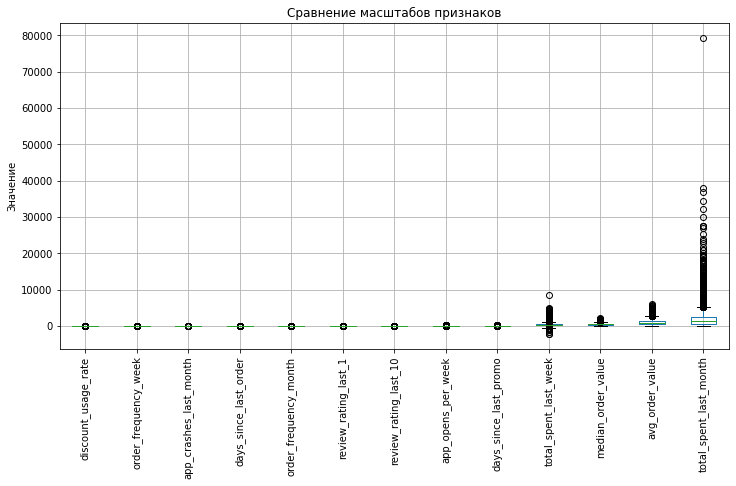

In [16]:
plt.figure(figsize = (12,6))

df_coffee[order].boxplot(rot = 90)

plt.title('Сравнение масштабов признаков')

plt.ylabel('Значение')

plt.show()

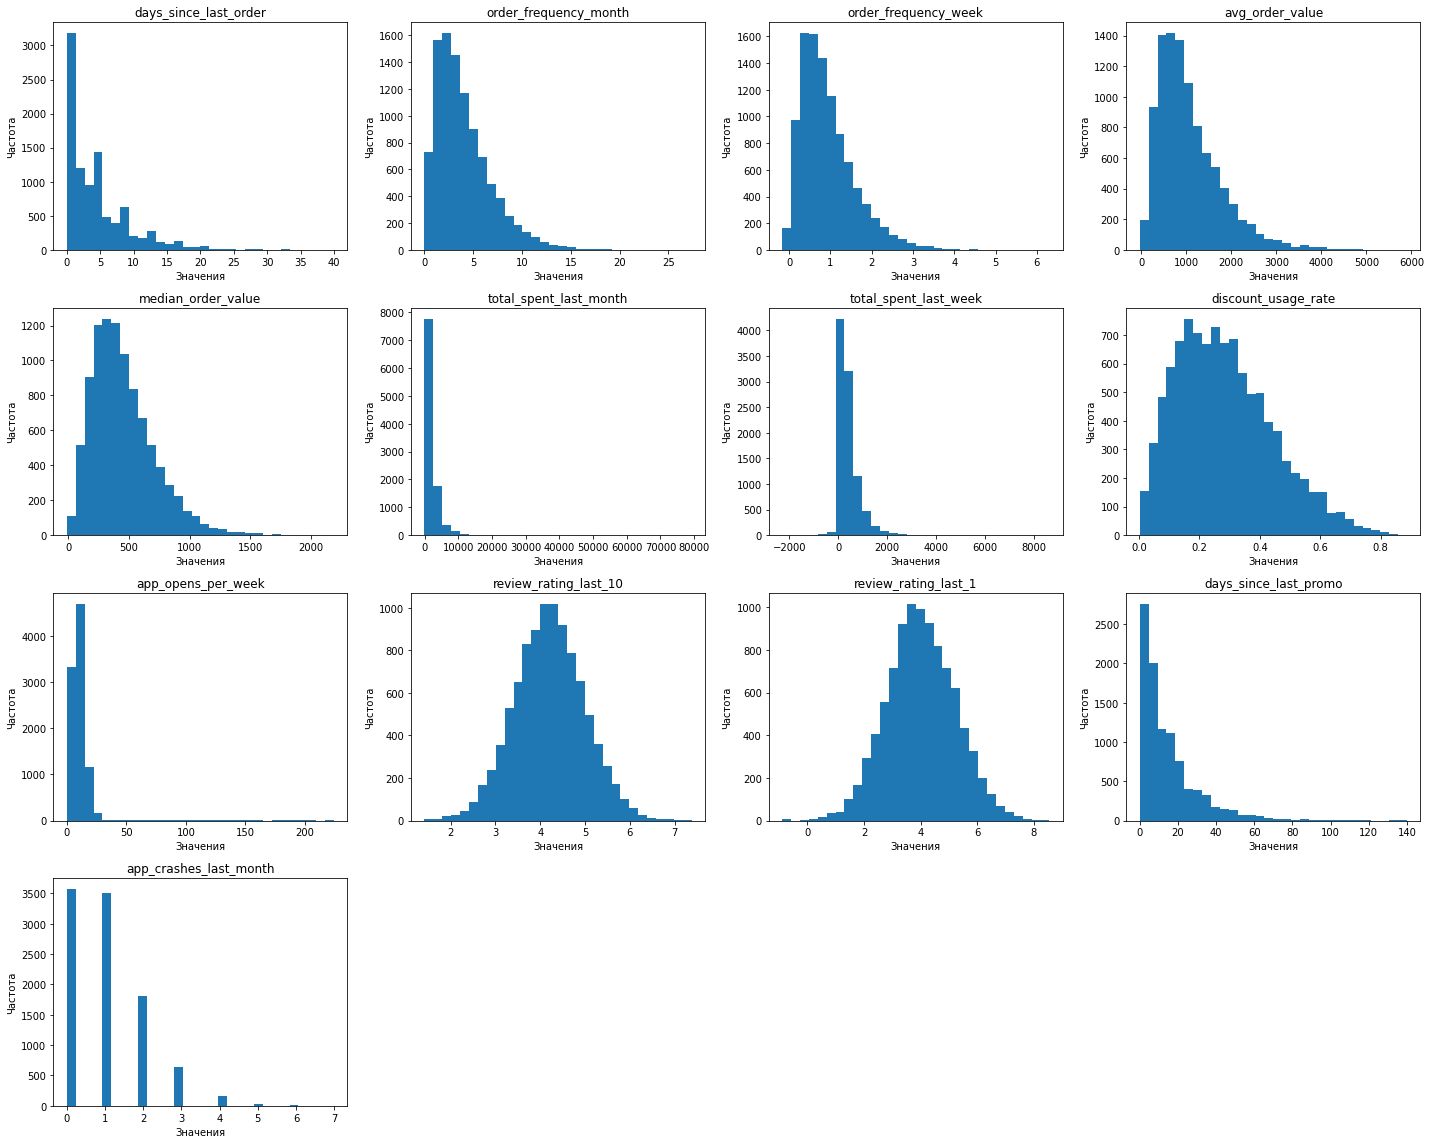

In [17]:
n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols

plt.figure(figsize = (5 * n_cols, 4 * n_cols))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df_coffee[col], bins = 30)
    plt.title(col)
    plt.xlabel('Значения')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По гистограммам видно, что признаки имеют сильную правостороннюю асимметрию, а также правые длинные хвосты:
- `days_since_last_order`,
- `order_frequency_month`,
- `order_frequency_week`,
- `avg_order_value`,
- `median_order_value`,
- `total_spent_last_month`, 
- `total_spent_last_week`,
- `discount_usage_rate`,
- `app_opens_per_week`,
- `days_since_last_promo`,
- `review_rating_last_10`,
- `review_rating_last_1`

В задачах оттока клиента эти "выбросы" имеют значения для модели, так как являются редкими случаями, которые влияют на предсказания оттока. 

- `days_since_last_order` - клиенты давно не делали заказы, что может являться признаком оттока 
- `order_frequency_month`/`order_frequency_week` - редкие клиенты, которые делают часто заказы, это важные клиенты, которые скорее всего не уйдут, можно использовать логарифмические преобразования для того, чтобы выровнять данные и сделать их более симметричными
- `avg_order_value`/`median_order_value` - правосторонняя асимметрия выражена слабее, правый хвост меньше. Необходимо оставить, а также попробовать также логарифмические преобразования для того, чтобы выровнять данные и сделать их более симметричными
- `total_spent_last_month` - сильно выраженная асимметрия, длинный правый хвост, также по boxplot видно сильно широкий масштаб по сравнению с остальными признаками, это могут быть редкие клиенты, которые делают большие заказы для корпораций, либо на  мероприятие, для сохранения точности лучше использовать логарифмические преобразования, чтобы не потерять редких, но прибыльных  клиентов
- `total_spent_last_week` - обнаружены аномальные минусовые значения, необходимо заменить их на `0`, что будет означать,что пользователь ничего не потратил за неделю, после чего провести логарифмические преобразования
- `discount_usage_rate` - есть асимметрия, но правый хвост короткий, выбросов нет, обработка не требуется
- `app_opens_per_week` - имеется длинный правый хвост и заметная асимметрия, это также могут быть редкие клиенты, которые часто заказывают из чего вытекает частое посещения приложения, можно испольщова логарифмические преобразования, чтобы не потерять редких, но прибыльных  клиентов
- `days_since_last_promo` - имеется длинный правый хвост и заметная асимметрия, но это также ключевые данные, так как у клиента могло не быть акций или промокодов, поэтому он ими давно не пользовался, что также может повлиять на отток
- `review_rating_last_10` / `review_rating_last_1` - распределение близкое к нормальному, имеет стабильное распределение.  Обработки не требуется
- `app_crashes_last_month` - это признак счетчик, выбросы могут быть при частых проблемах с приложением, но обрабатывать данный признак не нужно

Также признаки - `total_spent_last_month`, `avg_order_value`, `median_order_value`, `total_spent_last_week` выделяются по масштабу, значения распределены шире (коробка и усы длиннее), а также значения находятся на более высоком уровне. Это значит, что у некоторых признаков иной масштаб и большой разброс, поэтому необходимо будет провести масштабирование, чтобы уровнять значения признаков по важности. 

Необходимо проверить данные на явные дубликаты, чтобы они не исказили предсказания модели.

In [18]:
df_coffee.duplicated().sum()

0

Явных дубликатов не было обнаружено. 

Далее рассмотрим корреляцию признаков с целевой переменной.

In [19]:
#Категориальные признаки
cat_cols = [
    'last_coffee_type',
    'preferred_roast',
    'milk_preference',
    'coffee_bean_origin', 
    'last_drink_size',
    'subscription_status',
    'seasons',
    'phone_type',
    'geo_location'
]

#Бинарные признаки
binary_cols = [
    'notifications_enabled',
    'coffee_preference_change',
    'seasonal_menu_tried',
    'churn'
]

phik_cols = cols + cat_cols + binary_cols

#Копия датафрейма для смены типа данных
df_copy_phik = df_coffee[phik_cols].copy(deep = True)

df_copy_phik[cat_cols] = df_copy_phik[cat_cols].astype('category')

df_copy_phik[binary_cols] = df_copy_phik[binary_cols].astype('category')

In [20]:
correlation_matrix = df_copy_phik.phik_matrix(interval_cols = cols)

data_matrix = correlation_matrix.loc[correlation_matrix.index != 'churn'][['churn']].sort_values(by = 'churn', ascending=False)

display('Корреляционная  матрица с коэффициентом phi_k для переменной churn')
data_matrix 

'Корреляционная  матрица с коэффициентом phi_k для переменной churn'

,churn
app_crashes_last_month,0.853545
app_opens_per_week,0.126117
subscription_status,0.105164
order_frequency_week,0.080252
order_frequency_month,0.079332
total_spent_last_week,0.064183
geo_location,0.038881
total_spent_last_month,0.033998
review_rating_last_10,0.033943
avg_order_value,0.032515


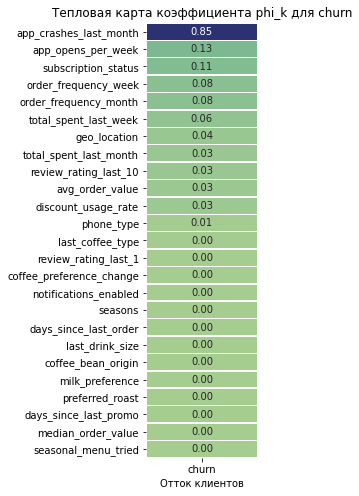

In [21]:
plt.figure(figsize = (2,8))

sns.heatmap(
    data_matrix,
    annot = True,
    fmt = '.2f',
    cmap = 'crest',
    linewidths = 0.5,
    cbar = False
)

plt.title('Тепловая карта коэффициента phi_k для churn')

plt.xlabel('Отток клиентов')

plt.show()

Заметна хорошая корреляция с:
- `app_crashes_last_month` - 0.85
- `app_opens_per_week` - 0.13
- `subscription_status` - 0.11

Умеренная корреляция заметна у признаков:
- `order_frequency_week` - 0.08
- `order_frequency_month` - 0.08
- `total_spent_last_week` - 0.06
- `geo_location` - 0.04
- `total_spent_last_month`- 0.04
- `review_rating_last_10` - 0.03
- `avg_order_value`- 0.03
- `discount_usage_rate` - 0.03

Также необходимо определить какие признаки оставить `order_frequency_week` или `order_frequency_month`, `total_spent_last_week`или `total_spent_last_month`. Для этого снова можно обратиться к раннее построенным гистограммам. 

Из них видно, что лучше оставить `order_frequency_week`, так как хвост короче, а также меньшая асимметрия. В матрице корреляции данный признак имеет больший коэффициент - order_frequency_week=`0.080252` > order_frequency_month=`0.079332`.

Также и с `total_spent_last_week`, из гистограммы видно более нормальное распределение данных, но необходимо их будет обработать  от отрицательных значений. В матрице корреляции также коэффициент total_spent_last_week=0.064 больше total_spent_last_month=0.034. Поэтому в модели будет использоваться  `total_spent_last_week`.

У остальных прихнаков 0 или практически 0 корреляция, они не повлияют на качество модели, либо ухудшат её: 
- `phone_type` - 0.005
- `last_coffee_type` - 0.004
- `review_rating_last_1` - 0.002
- `coffee_preference_change` - 0.00
- `notifications_enabled` - 0.00
- `seasons` - 0.00
- `days_since_last_order` - 0.00
- `last_drink_size` - 0.00
- `coffee_bean_origin` - 0.00
- `milk_preference` - 0.00
- `preferred_roast` - 0.00
- `days_since_last_promo` - 0.00
- `median_order_value` - 0.00
- `seasonal_menu_tried` - 0.00

In [22]:
X = df_coffee[[
    'app_crashes_last_month',
    'app_opens_per_week',
    'subscription_status',
    'order_frequency_week',
    'total_spent_last_week',
    'notifications_enabled',
    'phone_type',
    'review_rating_last_10',
    'avg_order_value',
    'discount_usage_rate'
]]

y = df_coffee['churn']

Датасет `df_coffee` содержит 10450 строк и 27 столбцов, в которых предоставлена информация из внутренних систем компании. 
Все значения в столбцах соответствуют своему описанию данных.

У целевой переменной наблюдается сильный дисбаланс, это заметно, потому что **положительный класс составляет ~ 6%**. Поэтому для оценки модели необходимо использовать метрику Precision-Recall AUC (PR AUC). 

Пропуски в категориальных признаках необходимо будет заполнить отдельной категорией, например 'unknown'. Если у пользователя нет предпочтений, то это может говорить об отсутсвии взаимодействия с приложением, что может повлиять на отток.

Пропуски в числовых признаках необходимо будет заполнить медианой значений, а также добавить столбец-индикатор, было ли там значение или нет, так как отсутсвие значения может зависеть от активности клиента.

Пропуски в бинарных признаках необходимо будет заполнить значением-индикатором -1, которое будет являеться индикатором о пропуске, который мог также появиться из-за не активного  пользователя.

Все категориальные признаки необходимо кодировать, так как модель может принимать только числовые признаки. 

Для данных признаков необходимо использовать TargetEncoder, так как уникальных значений больше 10:
- `geo_location` - идентификатор региона пользователя.

Для данных признаков необходимо использовать OneHotEncoder, так как уникальных значений меньше 10:
- `last_coffee_type` - сорт кофе, купленный пользователем в последний раз на момент сбора данных.
- `milk_preference` - предпочитаемый тип молока.
- `coffee_bean_origin` - страна происхождения зерна.
- `subscription_status` - тип подписки пользователя.
- `preferred_roast` - предпочитаемый тип обжарки.
- `last_drink_size` - размер последнего заказа, совершённого на момент сбора данных.
- `seasons` - текущее время года.
- `phone_type` - тип устройства, с которого пользователь чаще всего совершал покупки.

В задачах оттока клиента выбросы имеют значения для модели, так как являются редкими случаями, которые влияют на предсказания оттока. 

Признаки - `total_spent_last_month`, `avg_order_value`, `median_order_value`, `total_spent_last_week` выделяются по масштабу, значения распределены шире (коробка и усы длиннее), а также значения находятся на более высоком уровне. Это значит, что у некоторых признаков иной масштаб и большой разброс, поэтому необходимо будет провести масштабирование, чтобы уровнять значения признаков по важности. 

Заметна хорошая корреляция с:
- `app_crashes_last_month` - 0.85
- `app_opens_per_week` - 0.13
- `subscription_status` - 0.11

Умеренная корреляция заметна у признаков:
- `order_frequency_week` - 0.08
- `order_frequency_month` - 0.08
- `total_spent_last_week` - 0.06
- `geo_location` - 0.04
- `total_spent_last_month`- 0.04
- `review_rating_last_10` - 0.03
- `avg_order_value`- 0.03
- `discount_usage_rate` - 0.03

У остальных прихнаков 0 или практически 0 корреляция, они не повлияют на качество модели, либо ухудшат её. Такие признаки можно будет использовать в дальнейшнем для создания новых признаков, но ихнеобходимо будет проверить на корреляцию. 

Признаки, которые необходимо будет удалить: 
- `user_id` 
- `last_coffee_type` 
- `review_rating_last_1` 
- `coffee_preference_change` 
- `seasons` 
- `days_since_last_order` 
- `last_drink_size` 
- `coffee_bean_origin` 
- `milk_preference`
- `preferred_roast` 
- `days_since_last_promo` 
- `median_order_value` 
- `seasonal_menu_tried`
- `order_frequency_month` 
- `total_spent_last_month`
- `geo_location` 

`phone_type` и `notifications_enabled` оставим в датасете, чтобы в дальнейшем использовать их для создания нового признака.

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



Разделим данные на выборки: обучающую - 80%  (`X_train_val`, `y_train_val`) и тестовую - 20% (`X_test`, `y_test`).

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,  y,
    random_state = RANDOM_STATE,
    test_size = 0.2,
    shuffle = True,
    stratify = y
)

In [24]:
display(f"Размер обучающей выборки: {X_train_val.shape}")
display(f"Размер тестовой выборки: {X_test.shape}")
display(f"Доля положительного класса в train: {y_train_val.mean():.3f}")
display(f"Доля положительного класса в test: {y_test.mean():.3f}")

'Размер обучающей выборки: (8360, 10)'

'Размер тестовой выборки: (2090, 10)'

'Доля положительного класса в train: 0.060'

'Доля положительного класса в test: 0.060'

In [25]:
cat_cols = [
    'subscription_status',
    'phone_type'
]


num_cols = [
    'app_crashes_last_month',
    'app_opens_per_week',
    'order_frequency_week',
    'total_spent_last_week',
    'review_rating_last_10',
    'avg_order_value',
    'discount_usage_rate',
    'notifications_enabled'
]

Теперь необходимо написать пайплайны для обработки числовых и катигориальных признаков. 

Для числовых признаков:
- пропуски заполняются медианным значением
- минусовые значения заменяются `0`
- проводится стандартизация

Для категориальных признаков:
- пропуски заполняются значением `unknown`
- проводится кодирование признаков - 'subscription_status', 'phone_type' (OneHotEncoder) 

In [26]:
def neg_to_zero(X):
    return np.where(X < 0, 0, X)

#Пайплайн для обработки числовых признаков
num_pipeline = Pipeline(steps =  [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('neg_to_zero', FunctionTransformer(neg_to_zero)),
    ('scaler', StandardScaler())
])

In [27]:
#Пайплайн для обработки категориальных признаков
cat_pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'constant',  fill_value = 'unknown')),
        ('encoder', OneHotEncoder(sparse=False, handle_unknown = 'ignore'))
    ])

In [28]:
#Пайплайн для обработки признаков
preprocessor = ColumnTransformer(transformers =  [
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
])

Были созданы  пайплайны для обработки числовых и категориальных данных, после чего они были объеденены. 

## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

Для начала создадим базовую модель - DummyClassifier, чтобы на её основе сравнивать последующие модели.

In [29]:
N_FOLDS = 5

In [30]:
cv = StratifiedKFold(
    n_splits = N_FOLDS, 
    shuffle = True,
    random_state = RANDOM_STATE
)

In [31]:
baseline = DummyClassifier(strategy = 'prior',
                          random_state = RANDOM_STATE
                          )

In [32]:
res_baseline = cross_validate(baseline,
                             X_train_val,
                             y_train_val,
                             cv = cv,
                             scoring = 'average_precision',
                             return_train_score = True, 
                             return_estimator = True,
                             n_jobs = -1)

display(res_baseline)

display(f"Dummy PR-AUC (train_val): {res_baseline['test_score'].mean():.4f}")
display(f"STD Dummy PR-AUC (train_val): {res_baseline['test_score'].std():.4f}")

{'fit_time': array([0.00191331, 0.00128269, 0.00121498, 0.00121069, 0.00119448]),
 'score_time': array([0.00129032, 0.0012188 , 0.00124097, 0.00120044, 0.00119495]),
 'estimator': [DummyClassifier(random_state=42),
  DummyClassifier(random_state=42),
  DummyClassifier(random_state=42),
  DummyClassifier(random_state=42),
  DummyClassifier(random_state=42)],
 'test_score': array([0.05980861, 0.05980861, 0.0604067 , 0.0604067 , 0.0604067 ]),
 'train_score': array([0.06025718, 0.06025718, 0.06010766, 0.06010766, 0.06010766])}

'Dummy PR-AUC (train_val): 0.0602'

'STD Dummy PR-AUC (train_val): 0.0003'

Результаты метрики PR-AUC (train_val) У Dummy модели - 0.0602. 

In [33]:
logreg_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = RANDOM_STATE))
])

In [34]:
res_logreg = cross_validate(
    logreg_pipeline,
    X_train_val,
    y_train_val,
    cv = cv,
    scoring = 'average_precision',
    n_jobs = -1
)

In [35]:
display(f"LogisticRegression PR-AUC (train_val): {res_logreg['test_score'].mean():.4f}")
display(f"STD LogisticRegression PR-AUC (train_val): {res_logreg['test_score'].std():.4f}")

'LogisticRegression PR-AUC (train_val): 0.6479'

'STD LogisticRegression PR-AUC (train_val): 0.0422'

Значение LogisticRegression PR-AUC (train_val): 0.6479 что почти в 11 раз выше у модели Dummy. Это существенно превышает результаты baseline. 

У Dummy модели почти нулевой разброс **0.0003**, фолды почти не отличаются, поэтому модель всегда предсказывает одно и то же. У LogisticRegression среднее отклонение **0.0422**, умеренное, нет нестабильности и признаков переобучения.

Далее необходимо добавить новые признаки для улучшения модели. Чтобы увеличить среднее значение или уменьшить среднее отклонение.  

## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

На данном этапе необходимо добавить новые признаки для улучшения модели. Провести логарифмические преобразования. 

Новые признаки:
- `mobile_notifications_off` - phone_type и notifications_enabled, при наличии приложения выключены уведомления, пользователь может забыть о приложении
- `app_opens_per_order` - app_opens_per_week и order_frequency_week, интенсивность использования приложения
- `low_rating_activity` - review_rating_last_10 и  order_frequency_week, низкая оценка за последние заказы  и низкая активность
- `crash_rate` - app_crashes_last_month и app_opens_per_week, проблемы с приложением

Новые признаки при логарифмическом преобразовании:
- `order_frequency_week`
- `avg_order_value`
- `total_spent_last_week`
- `app_opens_per_week`

In [36]:
#Функция для создания новых признаков
def create_features(X):
    X_enhanced = X.copy()
    
    X_enhanced['mobile_notifications_off'] = ((X_enhanced['phone_type'].isin(['ios', 'android']))
                                             & (X_enhanced['notifications_enabled'] == 0)).astype(int)
    
    X_enhanced['app_opens_per_order'] = X_enhanced['app_opens_per_week'] / (X_enhanced['order_frequency_week'] + 1e-8)
    
    median_order = X_enhanced['order_frequency_week'].median()
    
    X_enhanced['low_rating_activity'] = ((X_enhanced['review_rating_last_10'] < 4) 
                                         & (X_enhanced['order_frequency_week'] < median_order)).astype(int)
    
    X_enhanced['crash_rate'] = X_enhanced['app_crashes_last_month'] / (X_enhanced['app_opens_per_week'] + 1)
    
    columns_for_drop = [
        'phone_type',
        'notifications_enabled'
    ]
    
    X_enhanced = X_enhanced.drop(columns = columns_for_drop)
    
    return X_enhanced

In [37]:
num_features = [
    'app_crashes_last_month',
    'review_rating_last_10',
    'discount_usage_rate',
    
    'mobile_notifications_off',
    'app_opens_per_order',
    'low_rating_activity',
    'crash_rate'
]

cat_features = [
    'subscription_status'
]

log_cols = [
    'order_frequency_week',
    'avg_order_value',
    'total_spent_last_week',
    'app_opens_per_week'
]

In [38]:
#Пайплайн для логарифмического преобразования
log_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('neg_to_zero', FunctionTransformer(neg_to_zero)),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])
#Пайплайн для обработки числовых признаков
num_features_pipeline = Pipeline(steps =  [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

#Пайплайн для обработки категориальных признаков
cat_features_pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'constant',  fill_value = 'unknown')),
        ('encoder', OneHotEncoder(sparse=False, handle_unknown = 'ignore'))
    ])

#Пайплайн для обработки признаков
preprocessor = ColumnTransformer(transformers =  [
    ('num', num_features_pipeline, num_features),
    ('log_num', log_transformer, log_cols),
    ('cat', cat_features_pipeline, cat_features)
])


advanced_pipeline = Pipeline(steps = [
    ('features', FunctionTransformer(create_features, validate=False)),
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = RANDOM_STATE))
])

In [39]:
res_logreg_advanced = cross_validate(
    advanced_pipeline,
    X_train_val,
    y_train_val,
    cv = cv,
    scoring = 'average_precision',
    n_jobs = -1
)

In [40]:
display(f"LogisticRegression с новыми признаками, PR-AUC (train_val): {res_logreg_advanced['test_score'].mean():.4f}")
display(f"STD LogisticRegression с новыми признаками, PR-AUC (train_val): {res_logreg_advanced['test_score'].std():.4f}")

'LogisticRegression с новыми признаками, PR-AUC (train_val): 0.6579'

'STD LogisticRegression с новыми признаками, PR-AUC (train_val): 0.0366'

In [41]:
display(f'{"Прирост +"  if (res_logreg_advanced["test_score"].mean() - res_logreg["test_score"].mean()) > 0 else "Ухудшение на -"} {(res_logreg_advanced["test_score"].mean() - res_logreg["test_score"].mean().round(4))}')

'Прирост + 0.009975493209346875'

Добавление новых признаков дало прирост среднего значения PR-AUC (train_val) на ~ 0,01, что улучшило качество модели, при этом стандартное отклонение почти не изменилось, что говорит о стабильности  модели. Новые признаки отражают поведедение пользователь лучше и дают дополнительную информацию. 

Теперь нужно проверит коэффициенты признаков, чтобы удалить лишние и упростить модель.

In [42]:
advanced_pipeline.fit(X_train_val, y_train_val)

preprocessor_fitted = advanced_pipeline.named_steps['preprocessor']

cat_transformer = preprocessor_fitted.named_transformers_['cat']

ohe = cat_transformer.named_steps['encoder']  

subscription_ohe_features = ohe.get_feature_names(['subscription_status'])

feature_name = (
    num_features +
    log_cols +
    list(subscription_ohe_features) 
)

coefs = advanced_pipeline.named_steps['model'].coef_[0]

coef_df = (
    pd.DataFrame({
       'feature' : feature_name,
        'coef' : coefs,
        'abc_coef' : np.abs(coefs)
    }).sort_values('abc_coef', ascending = False)
)

display('Коэффициенты признаков модели:')
coef_df

'Коэффициенты признаков модели:'

,feature,coef,abc_coef
0,app_crashes_last_month,1.930133,1.930133
14,subscription_status_pro,0.784172,0.784172
10,app_opens_per_week,0.631202,0.631202
12,subscription_status_none,-0.302861,0.302861
7,order_frequency_week,0.300613,0.300613
11,subscription_status_basic,-0.275576,0.275576
6,crash_rate,-0.208806,0.208806
15,subscription_status_unknown,-0.147156,0.147156
9,total_spent_last_week,0.142835,0.142835
3,mobile_notifications_off,0.120456,0.120456


По коэффициентам были выявлены такие сильные признаки:
- `app_crashes_last_month` - **+1.93** - Чем больше сбоев, тем выше вероятность ухода
- `subscription_status_pro` - **+0.78** - Чем выше ожидание, тем выше шанс ухода при каких-либо изменениях

Также были выявлены средние признаки, которые нужно будет проверить на корреляцию:
- `app_opens_per_week` - **+0.63**
- `subscription_status_none` - **-0.30**
- `order_frequency_week` - **+0.30**
- `subscription_status_basic` - **-0.28**
- `crash_rate` - **-0.21**
- `subscription_status_unknown` - **-0.15**
- `total_spent_last_week` - **+.14**
- `mobile_notifications_off` - **+.12**
- `low_rating_activity` - **+0.10**

Слабые признаки, которые имеют смысл в модели:
- `avg_order_value` - **-0.09**
- `subscription_status_premium` - **-0.06**
- `app_opens_per_order` - **-0.03**

Слабые признаки, которые следует удалить:
- `discount_usage_rate` - **-0.011**
- `review_rating_last_10` - **0.0009**

In [43]:
X_features = create_features(X_train_val)

X_corr = X_features[[
    'app_crashes_last_month',
    'crash_rate',
    'app_opens_per_week',
    'order_frequency_week',
    'app_opens_per_order',
    'review_rating_last_10',
    'mobile_notifications_off',
    'low_rating_activity',
    'avg_order_value',
    'total_spent_last_week'
]]

In [44]:
corr_matrix = X_corr.corr(method = 'spearman')

corr_matrix

,app_crashes_last_month,crash_rate,app_opens_per_week,order_frequency_week,app_opens_per_order,review_rating_last_10,mobile_notifications_off,low_rating_activity,avg_order_value,total_spent_last_week
app_crashes_last_month,1.000000,0.910054,-0.000153,-0.014981,0.017310,0.033749,-0.005441,-0.010607,-0.006577,-0.016728
crash_rate,0.910054,1.000000,-0.300227,-0.145006,-0.101742,0.036280,0.000290,0.030384,-0.011372,-0.111302
app_opens_per_week,-0.000153,-0.300227,1.000000,0.437626,0.344839,-0.002365,-0.005363,-0.154349,-0.004795,0.317462
order_frequency_week,-0.014981,-0.145006,0.437626,1.000000,-0.579795,0.008208,-0.004210,-0.407011,-0.004026,0.735724
app_opens_per_order,0.017310,-0.101742,0.344839,-0.579795,1.000000,-0.006399,0.002289,0.237385,-0.000031,-0.427100
review_rating_last_10,0.033749,0.036280,-0.002365,0.008208,-0.006399,1.000000,0.009622,-0.512482,-0.007813,0.000489
mobile_notifications_off,-0.005441,0.000290,-0.005363,-0.004210,0.002289,0.009622,1.000000,-0.005023,-0.009597,-0.010564
low_rating_activity,-0.010607,0.030384,-0.154349,-0.407011,0.237385,-0.512482,-0.005023,1.000000,0.004917,-0.278976
avg_order_value,-0.006577,-0.011372,-0.004795,-0.004026,-0.000031,-0.007813,-0.009597,0.004917,1.000000,0.508205
total_spent_last_week,-0.016728,-0.111302,0.317462,0.735724,-0.427100,0.000489,-0.010564,-0.278976,0.508205,1.000000


Что видно по матрице корреляции:
- `app_crashes_last_month` и `crash_rate` между собой коррелируют на 0.91, что говорит о мультиколиниарности, поэтому необходимо оставить только один из них - `app_crashes_last_month`
- `app_opens_per_week` и `app_opens_per_order` имеют умеренную корреляцию, но лучше будет оставить только один признак - `app_opens_per_order`
- `mobile_notifications_off` имеет со всеми остальными признаки низкую корреляцию, поэтому остаётся
- `low_rating_activity` имеет со всеми остальными признаки низкую корреляцию, поэтому остаётся
- `total_spent_last_week` необходимо удалить, так как он имеет высокую корреляцию с `order_frequency_week`

Необходимо удалить такие признаки:
- `discount_usage_rate`
- `review_rating_last_10`
- `crash_rate`
- `app_opens_per_week`
- `total_spent_last_week`

Теперь изменим функцию и списки признаков, чтобы при их использовании для дальшних моделей не создавались не нужные признаки.

Из функции будет удалено создание признака `crash_rate`. Пайплайны не меняются.

In [45]:
#Функция для создания новых признаков
def create_features(X):
    X_enhanced = X.copy()
    
    X_enhanced['mobile_notifications_off'] = ((X_enhanced['phone_type'].isin(['ios', 'android']))
                                             & (X_enhanced['notifications_enabled'] == 0)).astype(int)
    
    X_enhanced['app_opens_per_order'] = X_enhanced['app_opens_per_week'] / (X_enhanced['order_frequency_week'] + 1e-8)
    
    median_order = X_enhanced['order_frequency_week'].median()
    
    X_enhanced['low_rating_activity'] = ((X_enhanced['review_rating_last_10'] < 4) 
                                         & (X_enhanced['order_frequency_week'] < median_order)).astype(int)
    
    columns_for_drop = [
        'phone_type',
        'notifications_enabled'
    ]
    
    X_enhanced = X_enhanced.drop(columns = columns_for_drop)
    
    return X_enhanced

In [46]:
num_features_del = [
    'app_crashes_last_month',
    'mobile_notifications_off',
    'app_opens_per_order',
    'low_rating_activity'
]

cat_features_del = [
    'subscription_status'
]

log_cols_del = [
    'order_frequency_week',
    'avg_order_value'
]

In [47]:
#Пайплайн для логарифмического преобразования
log_transformer_del = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('neg_to_zero', FunctionTransformer(neg_to_zero)),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])
#Пайплайн для обработки числовых признаков
num_del_pipeline = Pipeline(steps =  [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

#Пайплайн для обработки категориальных признаков
cat_del_pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer(strategy = 'constant',  fill_value = 'unknown')),
        ('encoder', OneHotEncoder(sparse=False, handle_unknown = 'ignore'))
    ])

#Пайплайн для обработки признаков
preprocessor_del = ColumnTransformer(transformers =  [
    ('num', num_del_pipeline, num_features_del),
    ('log_num', log_transformer_del, log_cols_del),
    ('cat', cat_del_pipeline, cat_features_del)
])


advanced_pipeline_del = Pipeline(steps = [
    ('features', FunctionTransformer(create_features, validate=False)),
    ('preprocessor', preprocessor_del),
    ('model', LogisticRegression(class_weight = 'balance', max_iter = 1000, random_state = RANDOM_STATE))
])

Теперь проведем ещё одну кросс-валидацию, чтобы проверить метрики после удаления лишних признаков.

In [48]:
res_pruned = cross_validate(
    advanced_pipeline_del,
    X_train_val,
    y_train_val,
    cv = cv,
    scoring = 'average_precision',
    n_jobs = -1
)

In [49]:
display(f"LogisticRegression с новыми признаками, PR-AUC (train_val): {res_pruned['test_score'].mean():.4f}")
display(f"STD LogisticRegression с новыми признаками, PR-AUC (train_val): {res_pruned['test_score'].std():.4f}")

'LogisticRegression с новыми признаками, PR-AUC (train_val): 0.6669'

'STD LogisticRegression с новыми признаками, PR-AUC (train_val): 0.0439'

После добавления новых признаков качество модели выросло PR-AUC (train_val) до **0.6669**. 

Далее был проведён анализ коэффициентов и корреляции новых признаков и были удалены такие признаки:
- `discount_usage_rate`
- `app_opens_per_week`
- `crash_rate`
- `total_spent_last_week`
- `review_rating_last_10`

Удаление признаков с низким коэффициентом и мультиколиниарностью повысило качество модели до PR-AUC (train_val): **0.6669**. Модель стала проще и интерпретируемой.

Для дальнейшей работы будет выбрана модель с удаления слабых и коррелирующих, так как в данной задаче важен показатель PR-AUC, чем выше, тем лучше.

## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

Гиперпараметры, с которыми далее пройдут эксперементы:
- C - 0.1, 1, 10
- penalty - `l1, l2`, 
- solver - `liblinear, lbfgs`
- class_weight - `balanced`

In [50]:
#Набор гиперпараметров
C_list = [0.01, 0.1, 1, 10]
penalty_list = ['l1', 'l2']

solver_map = {
    'l1' : 'liblinear',
    'l2' : ['liblinear', 'lbfgs']
}

In [51]:
results = []

In [52]:
for penalty in penalty_list:
    solvers = solver_map[penalty]
    if isinstance(solvers, str):
        solvers = [solvers]
        
    for solver in solvers:
        for C in C_list:
            model = LogisticRegression(
                C = C,
                penalty = penalty,
                solver = solver,
                class_weight = 'balanced', 
                max_iter = 1000, 
                random_state = RANDOM_STATE
            )
            
            pipeline = Pipeline(steps = [
                ('features', FunctionTransformer(create_features, validate=False)),
                ('preprocessor', preprocessor_del),
                ('model', model)
            ])
            
            res = cross_validate(
                    pipeline,
                    X_train_val,
                    y_train_val,
                    cv = cv,
                    scoring = 'average_precision',
                    n_jobs = -1,
                    return_train_score = True
            )
            
            results.append({
                    'C' : C,
                    'penalty' : penalty,
                    'solver' : solver,
                    'class_weight'  : 'balanced',
                    'PR_AUC_mean' : res['test_score'].mean().round(4),
                    'PR_AUC_std' : res['test_score'].std().round(4)
            })

In [53]:
results_df = pd.DataFrame(results)

results_sorted = results_df.sort_values('PR_AUC_mean', ascending = False)

results_sorted

,C,penalty,solver,class_weight,PR_AUC_mean,PR_AUC_std
4,0.01,l2,liblinear,balanced,0.6674,0.0425
8,0.01,l2,lbfgs,balanced,0.6667,0.0437
0,0.01,l1,liblinear,balanced,0.6631,0.0461
1,0.10,l1,liblinear,balanced,0.6590,0.0423
9,0.10,l2,lbfgs,balanced,0.6585,0.0434
5,0.10,l2,liblinear,balanced,0.6581,0.0436
2,1.00,l1,liblinear,balanced,0.6559,0.0432
6,1.00,l2,liblinear,balanced,0.6556,0.0433
10,1.00,l2,lbfgs,balanced,0.6556,0.0434
7,10.00,l2,liblinear,balanced,0.6555,0.0433


По итогам перебора гиперпаметров была определена лучшая модель. Лучший результат метрики PR_AUC_mean = 0.6674, с гиперпараметрами:
- C = **0.01**
- penalty = **l2**
- solver = **liblinear**
- class_weight = **balanced**	

Лучшая модель стабильная, не переобучилась. 

Также по таблице заметно, что чем больше `C`, тем хуже метрика. 

Выбранную модель необходимо проверить на тестовой выборке для итоговой оценки.

## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


Объеденим лучшую конфигурацию гиперпараметров с оптимальным набором признаков. После чего обучим модель на данных для кросс-валидации и оценим на отложенной тестовой выборке.

In [54]:
final_pipeline = Pipeline(steps = [
    ('features', FunctionTransformer(create_features, validate=False)),
    ('preprocessor', preprocessor_del),
    ('model', LogisticRegression(class_weight = 'balanced', 
                                 max_iter = 1000, 
                                 random_state = RANDOM_STATE,
                                 C = 0.01,
                                 solver = 'liblinear',
                                 penalty = 'l2'
                                 ))
])

In [55]:
final_pipeline.fit(X_train_val, y_train_val)

y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

In [56]:
final_score = average_precision_score(y_test, y_pred_proba)
display(f'PR-AUC на тестовой выборке: {final_score.round(4)}')

'PR-AUC на тестовой выборке: 0.6936'

На тестовой выборке модель показала результаты метрики **PR-AUC - 0.6936.** 

Модель достаточно хорошо различает классы. Это в 12 раз выше, чем baseline модель. 

С учетом стабильности и хороших показателей метрики модель можно рекомендовать к внедрению.

## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

Тип модели:
- `линейная модель — LogisticRegression`. 
- В качестве базовой модели - `DummyClassifier`.

Целевая переменная: `churn - перестал ли пользователь пользоваться сервисом.

Метрики качества модели, которые использовались: 
- Precision-Recall AUC (PR AUC).

Занчения у Dummy модели 0.0602. 

Значение LogisticRegression PR-AUC (train_val): 0.6479 что почти в 11 раз выше у модели Dummy.

У Dummy модели почти нулевой разброс **0.0003**, фолды почти не отличаются, поэтому модель всегда предсказывает одно и то же. У LogisticRegression среднее отклонение **0.0422**, умеренное, нет нестабильности и признаков переобучения.

Далее были добавлены новые признаки для улучшения модели. Чтобы увеличить среднее значение или уменьшить среднее отклонение.  

После добавления новых признаков качество модели выросло PR-AUC (train_val) до **0.6669**. 

Далее был проведён анализ коэффициентов , по которому были выявлены такие сильные признаки:
- `app_crashes_last_month` - **+1.93** - Чем больше сбоев, тем выше вероятность ухода
- `subscription_status_pro` - **+0.78** - Чем выше ожидание, тем выше шанс ухода при каких-либо изменениях

Были выявлены средние признаки, которые после были проверены на корреляцию:
- `app_opens_per_week` - **+0.63**
- `subscription_status_none` - **-0.30**
- `order_frequency_week` - **+0.30**
- `subscription_status_basic` - **-0.28**
- `crash_rate` - **-0.21**
- `subscription_status_unknown` - **-0.15**
- `total_spent_last_week` - **+.14**
- `mobile_notifications_off` - **+.12**
- `low_rating_activity` - **+0.10**

Также был проведён анализ корреляции новых признаков и были удалены такие признаки:
- `discount_usage_rate`
- `app_opens_per_week`
- `crash_rate`
- `total_spent_last_week`
- `review_rating_last_10`

Удаление признаков с низким коэффициентом и мультиколиниарностью повысило качество модели до PR-AUC (train_val): **0.6669**. 

Для дальнейшей работы будет выбрана модель с удаления слабых и коррелирующих, так как в данной задаче важен показатель PR-AUC, чем выше, тем лучше.

По итогам перебора гиперпаметров была определена лучшая модель. Лучший результат метрики PR_AUC_mean = 0.6674, с гиперпараметрами:
- C = **0.01**
- penalty = **l2**
- solver = **liblinear**
- class_weight = **balanced**	

Также данная модель показала хорошие результаты **PR-AUC на тестовой выборке: 0.6936** это в 12 раз выше baseline модели. 

Модель хорошо учитывает положительные признаки. При удалении признаков с низким коэффициентом и взаимной корреляцией, а также с оптимальным подбором гиперпараметров, модель стала стабильнее и уменьшился риск переобучения.

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

Сохраним финальную модель и пайплайн

In [57]:
joblib.dump(final_pipeline, 'model_outflow_coffee.joblib')

['model_outflow_coffee.joblib']

Теперь убедимся, что сохраненная модель работает верно. Загрузим артефакты и  проверим на тестовой выборке.

In [58]:
loaded_pipeline = joblib.load('model_outflow_coffee.joblib') 
display("Пайплайн загружен")

'Пайплайн загружен'

In [59]:
y_pred_proba = loaded_pipeline.predict_proba(X_test)[:, 1]

pr_auc_test = average_precision_score(y_test, y_pred_proba)
display(f'PR-AUC на тестовой выборке после загрузки: {pr_auc_test.round(4)}')

'PR-AUC на тестовой выборке после загрузки: 0.6936'

Значение PR-AUC на тестовой выборке после загрузки: 0.6936,  что равно значению полученому до сохранения PR-AUC на тестовой выборке до сохранения: 0.6936. Поэтому сохранение и загрузка прошли корректно.

**Ссылка для скачивания сохранённых файлов:** https://github.com/OliSherbak/Project_11_of_the_sprint.git